In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import re
import transformers
import torch
import torch.nn as nn
import pickle

from nltk.corpus import stopwords
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from transformers import RobertaModel, get_linear_schedule_with_warmup, RobertaTokenizer
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def remove_comments_and_docstrings(code):
    # Remove triple-quoted docstrings (greedy, multiline-aware)
    code = re.sub(r'("""[\s\S]*?"""|\'\'\'[\s\S]*?\'\'\')', '', code, flags=re.MULTILINE|re.DOTALL)

    # Remove line comments (after code), but keep code before #
    lines = code.splitlines()
    cleaned = []
    for line in lines:
        # Only remove comment if it's not inside a string literal
        code_only = re.sub(r'#.*', '', line)
        if code_only.strip():
            cleaned.append(code_only.rstrip())
    return '\n'.join(cleaned)

file_path_csv = "/content/codesearchnet_python.csv"
df = pd.read_csv(file_path_csv)
df = df.iloc[:2000]
df = df[df['G'] != 'C']

df['Code'] = df['Code'].apply(remove_comments_and_docstrings)

In [4]:
# Display basic info
print(len(df))
display(df.head(10)) # Show the first few rows
#display(df.info())  # Show column data types
#print(df.columns)

1787


,Project Name,Function Name,Code,Docstring,E,W,R,X,G,Comments,CFP
0,tornadoweb/tornado,FacebookGraphMixin.facebook_request,"async def facebook_request(\n self,\n ...","Fetches the given relative API path, e.g., ""/b...",1.0,0.0,0.0,1.0,A,NaN,2.0
1,DataDog/integrations-core,MongoClient.get_database,"def get_database(self, name=None, codec_option...",Get a :class:`~pymongo.database.Database` with...,1.0,0.0,0.0,1.0,A,"Sadece db ile bağlantı kurmak için, son kullan...",2.0
3,ambitioninc/python-logentries-api,SpecialAlertBase._login,"def _login(self, username, password):\n ...",._login() makes three requests: * One to the /...,2.0,0.0,0.0,1.0,A,2 0 0 2,3.0
4,benjamin-hodgson/asynqp,connect_and_open_channel,"def connect_and_open_channel(host='localhost',...",Connect to an AMQP server and open a channel o...,1.0,0.0,0.0,1.0,B,admin için.,2.0
5,django-userena-ce/django-userena-ce,UserenaAuthenticationBackend.authenticate,"def authenticate(self, request, identification...",Authenticates a user through the combination e...,1.0,0.0,1.0,1.0,A,NaN,3.0
7,briancappello/flask-unchained,SecurityUtilsService.verify_password,"def verify_password(self, user, password):\n ...",Returns ``True`` if the password is valid for ...,1.0,0.0,0.0,0.0,A,kullanıcıdan alınan password hardcoded kontrol...,1.0
8,datamachine/twx.botapi,restrict_chat_member,"def restrict_chat_member(chat_id, user_id, unt...",Use this method to kick a user from a group or...,1.0,0.0,0.0,1.0,B,"chat ban, kullanıcıya bildirim gitmiyor, admin...",2.0
9,CivicSpleen/ambry,find_config_file,"def find_config_file(file_name, extra_path=Non...",Find a configuration file in one of these dire...,0.0,0.0,0.0,1.0,A,error fırlatıyor,1.0
10,tinybike/coinbridge,Bridge.sendfrom,"def sendfrom(self, user_id, dest_address, amou...",Send coins from user's account. Args: user_id ...,1.0,0.0,0.0,1.0,A,"coin gönderme işlemi, kayıtlar direkt database...",2.0
11,aio-libs/aioredis,GenericCommandsMixin.move,"def move(self, key, db):\n if not isins...",Move key from currently selected database to s...,1.0,0.0,0.0,1.0,A,NaN,2.0


# **TRAIN TEST SPLIT**

In [5]:
X = df[['Code']]  # Features
y = df[['E', 'W', 'R', 'X', 'CFP']]
 # Multiple targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
df_train = pd.DataFrame({'code': X_train['Code'], 'data_movements': y_train.values.tolist()}).reset_index(drop=True)
df_test = pd.DataFrame({'code': X_test['Code'], 'data_movements': y_test.values.tolist()}).reset_index(drop=True)

In [7]:
display(df_train)

,code,data_movements
0,"def update_guest_additions(self, source, argum...","[0.0, 0.0, 0.0, 1.0, 1.0]"
1,"def discharge_token(self, username):\n ...","[2.0, 0.0, 0.0, 1.0, 3.0]"
2,"def callback_request(self, msg, reply_cb=None,...","[1.0, 0.0, 0.0, 2.0, 3.0]"
3,"def create(self, display_name, content=None):\...","[2.0, 0.0, 0.0, 1.0, 3.0]"
4,"def keypair_field_data(request, include_empty_...","[2.0, 0.0, 0.0, 1.0, 3.0]"
...,...,...
1424,"async def log_source(self, **params):\n\t\tif ...","[1.0, 1.0, 0.0, 1.0, 3.0]"
1425,def get_user_config():\n initialconf = norm...,"[1.0, 0.0, 0.0, 0.0, 1.0]"
1426,"def read_file(self, filename):\n logger...","[1.0, 0.0, 0.0, 1.0, 2.0]"
1427,def get_list(**kwargs):\n opts = salt.utils...,"[1.0, 0.0, 0.0, 1.0, 2.0]"


In [8]:
display(df_test)

,code,data_movements
0,def connect_options_namespaced_service_proxy(s...,"[2.0, 0.0, 0.0, 1.0, 3.0]"
1,"def select_flair(self, item, flair_template_id...","[2.0, 0.0, 0.0, 2.0, 4.0]"
2,def send_reset_password_instructions(user):\n ...,"[1.0, 0.0, 1.0, 0.0, 2.0]"
3,def _get_base_model(self):\n if self.mo...,"[0.0, 0.0, 0.0, 1.0, 1.0]"
4,"def get_unread(self, include_me=False, include...","[2.0, 0.0, 0.0, 1.0, 3.0]"
...,...,...
353,"def restore(self, password, db, dump, copy=Fal...","[1.0, 1.0, 0.0, 1.0, 3.0]"
354,"def epost(database, ids: List[str], webenv=Fal...","[0.0, 0.0, 0.0, 1.0, 1.0]"
355,"def permission_check(data, command_permissions...","[1.0, 0.0, 0.0, 1.0, 2.0]"
356,"def server_error(request, template_name='500.h...","[0.0, 0.0, 1.0, 1.0, 2.0]"


In [9]:
REMOVE_COMMENTS = True
COMMENTS_POSTFIX = "with_comments" if not REMOVE_COMMENTS else "without_comments"

def dedoc(a):
    # remove docstrings (between triple quotes or triple double quotes)
    a = re.sub(r'"""(.|\n)*?"""', '', a)
    a = re.sub(r"'''(.|\n)*?'''", '', a)
    if REMOVE_COMMENTS:
        a = re.sub(r'#.*', '', a)
    return a

In [10]:
train_codes = df_train.code.apply(dedoc).values
test_codes = df_test.code.apply(dedoc).values

In [11]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [12]:
# Convert lists of strings to lists of numbers
train_data_list = df_train['data_movements'].apply(lambda x: list(map(float, x))).tolist()
test_data_list = df_test['data_movements'].apply(lambda x: list(map(float, x))).tolist()

train_labels = torch.tensor(train_data_list, dtype=torch.float32)
test_labels = torch.tensor(test_data_list, dtype=torch.float32)

In [13]:
MAX_LEN = 512

input_ids = []
attention_masks = []

for code in train_codes:
    encoded_dict = tokenizer.encode_plus(
        code,
        add_special_tokens=False,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
train_labels = train_labels.clone().detach()


In [14]:
print(input_ids.shape)

torch.Size([1429, 512])


In [15]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, train_labels)

# Create a 90-10 train-validation split.

train_size = int(0.9 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,286 training samples
  143 validation samples


In [16]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [17]:
class CodeBERTForRegression(nn.Module):
    def __init__(self):
        super(CodeBERTForRegression, self).__init__()
        self.codebert = RobertaModel.from_pretrained(
            "microsoft/codebert-base",
            output_attentions=False,
            output_hidden_states=False
        )
        self.regressor = nn.Linear(self.codebert.config.hidden_size, 5)  # 5 outputs for regression

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        regression_output = self.regressor(pooled_output)
        return regression_output

model = CodeBERTForRegression().to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [18]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [19]:
class RMSELoss(nn.Module):
    def forward(self, preds, targets):
        return torch.sqrt(nn.MSELoss()(preds, targets))

mae_loss_fn = nn.L1Loss()  # MAE Loss
rmse_loss_fn = RMSELoss()  # RMSE Loss

In [20]:
# Number of training epochs
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Can tune this for better convergence
    num_training_steps=total_steps
)


In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# **RUN TRAINING**

In [22]:
# Function to compute MAE and RMSE
def compute_mae_rmse(preds, targets):
    preds = preds.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()

    mae = np.mean(np.abs(preds - targets))  # MAE
    rmse = np.sqrt(np.mean((preds - targets) ** 2))  # RMSE

    return mae, rmse

def compute_accuracy(preds, targets, tolerance=0.5):
    # Farkı al
    diff = torch.abs(preds - targets)
    # Toleransa göre doğru tahminleri bul (bool tensor)
    correct = (diff <= tolerance).float()
    # Ortalama: doğru tahminlerin oranı
    accuracy = correct.mean().item()
    return accuracy



seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Create an empty CSV to log training statistics
with open(f'training_stats_{COMMENTS_POSTFIX}.csv', 'w') as f:
    f.write('epoch,TrainLoss,ValidLoss,ValidMAE,ValidRMSE,ValidAcc,TrainTime,ValidTime\n')


total_t0 = time.time()

best_val_mae = float("inf")

train_loss_fn = mae_loss_fn

# Training
for epoch_i in range(epochs):
    print(f'\n======== Epoch {epoch_i + 1} of {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)

        loss = train_loss_fn(outputs, b_labels)
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate average loss for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure training time
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch took: {training_time}")

    # Validation

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_val_loss = 0
    total_mae = 0
    total_rmse = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, attention_mask=b_input_mask)

            loss = train_loss_fn(outputs, b_labels)
            total_val_loss += loss.item()

            mae, rmse = compute_mae_rmse(outputs, b_labels)
            total_mae += mae
            total_rmse += rmse

            accuracy = compute_accuracy(outputs, b_labels, tolerance=0.5)
            total_accuracy += accuracy


    # Compute average validation losses
    avg_val_loss = total_val_loss / len(validation_dataloader)
    avg_val_mae = total_mae / len(validation_dataloader)
    avg_val_rmse = total_rmse / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    avg_val_accuracy = total_accuracy / len(validation_dataloader)

    print(f"  Accuracy (±0.5 tolerance): {avg_val_accuracy:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  MAE: {avg_val_mae:.4f} | RMSE: {avg_val_rmse:.4f}")
    print(f"  Validation took: {validation_time}")

    # Save the model if MAE improves
    if avg_val_mae < best_val_mae:
        torch.save(model.state_dict(), f'codebert_best_model_{COMMENTS_POSTFIX}.pt')
        best_val_mae = avg_val_mae

    # Store training stats for the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'TrainLoss': avg_train_loss,
            'ValidLoss': avg_val_loss,
            'ValidMAE': avg_val_mae,
            'ValidRMSE': avg_val_rmse,
            'TrainTime': training_time,
            'ValidTime': validation_time
        }
    )

    # Append training stats to CSV file
    with open(f'training_stats_{COMMENTS_POSTFIX}.csv', 'a') as f:
        f.write(f"{epoch_i + 1},{avg_train_loss:.4f},{avg_val_loss:.4f},{avg_val_mae:.4f},{avg_val_rmse:.4f},{avg_val_accuracy:.4f},{training_time},{validation_time}\n")

print("\nTraining complete!")
print(f"Total training time: {format_time(time.time() - total_t0)}")


======== Epoch 1 of 5 ========
Training...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


  Average training loss: nan
  Training epoch took: 0:01:49

Running Validation...
  Accuracy (±0.5 tolerance): 0.7247
  Validation Loss: 0.3621
  MAE: 0.3621 | RMSE: 0.5613
  Validation took: 0:00:04

======== Epoch 2 of 5 ========
Training...

  Average training loss: nan
  Training epoch took: 0:01:52

Running Validation...
  Accuracy (±0.5 tolerance): 0.7217
  Validation Loss: 0.3412
  MAE: 0.3412 | RMSE: 0.5385
  Validation took: 0:00:04

======== Epoch 3 of 5 ========
Training...

  Average training loss: nan
  Training epoch took: 0:01:53

Running Validation...
  Accuracy (±0.5 tolerance): 0.7325
  Validation Loss: 0.3422
  MAE: 0.3422 | RMSE: 0.5341
  Validation took: 0:00:04

======== Epoch 4 of 5 ========
Training...

  Average training loss: nan
  Training epoch took: 0:01:52

Running Validation...
  Accuracy (±0.5 tolerance): 0.7354
  Validation Loss: 0.3279
  MAE: 0.3279 | RMSE: 0.5069
  Validation took: 0:00:04

======== Epoch 5 of 5 ========
Training...

  Average train

# **LOAD AND TEST TRAINED MODEL**

In [23]:
# Load best model
model = CodeBERTForRegression().to(device)
model.load_state_dict(torch.load(f'codebert_best_model_{COMMENTS_POSTFIX}.pt'))
model.eval()

CodeBERTForRegression(
  (codebert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [24]:
test_codes = df_test.code.apply(dedoc).values
true_labels = df_test.data_movements.tolist()

test_input_ids = []
test_attention_masks = []

for code in test_codes:
    encoded_dict = tokenizer.encode_plus(
        code,
        add_special_tokens=True,
        max_length=256,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

In [25]:
# Create TensorDataset and DataLoader
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

## **GET PREDICTIONS**

In [26]:
# Predict
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        preds = outputs.detach().cpu().numpy()
        predictions.extend(preds.tolist())

# Save results to DataFrame
df_output = pd.DataFrame()
df_output['code'] = df_test['code']

# Separate actual labels into 5 columns
df_output[['label_E', 'label_W', 'label_R', 'label_X', 'label_CFP']] = pd.DataFrame(true_labels)

# Separate the estimated values ​​into 5 columns
df_output[['pred_E', 'pred_W', 'pred_R', 'pred_X', 'pred_CFP']] = pd.DataFrame(predictions)

# Separate columns to compare totals E+W+R+X
df_output['label_CFP_sum_from_parts'] = df_output[['label_E', 'label_W', 'label_R', 'label_X']].sum(axis=1)
df_output['pred_CFP_sum_from_parts'] = df_output[['pred_E', 'pred_W', 'pred_R', 'pred_X']].sum(axis=1)

# Rounded values ​​
df_output['label_CFP_rounded'] = df_output['label_CFP'].round()
df_output['pred_CFP_rounded'] = df_output['pred_CFP'].round()

# Save results as CSV
import os
os.makedirs("results", exist_ok=True)
output_path = f"results/predictions_{len(df_output)}_{COMMENTS_POSTFIX}.csv"
df_output.to_csv(output_path, index=False)

# Display
print(f"Saved predictions to: {output_path}")
display(df_output.head())


Saved predictions to: results/predictions_358_without_comments.csv


,code,label_E,label_W,label_R,label_X,label_CFP,pred_E,pred_W,pred_R,pred_X,pred_CFP,label_CFP_sum_from_parts,pred_CFP_sum_from_parts,label_CFP_rounded,pred_CFP_rounded
0,def connect_options_namespaced_service_proxy(s...,2.0,0.0,0.0,1.0,3.0,0.990963,-0.015874,-0.038152,0.975368,2.120025,3.0,1.912306,3.0,2.0
1,"def select_flair(self, item, flair_template_id...",2.0,0.0,0.0,2.0,4.0,0.808021,-0.038586,0.522985,0.943548,2.636178,4.0,2.235968,4.0,3.0
2,def send_reset_password_instructions(user):\n ...,1.0,0.0,1.0,0.0,2.0,1.028881,0.123938,0.223464,0.894730,2.378112,2.0,2.271013,2.0,2.0
3,def _get_base_model(self):\n if self.mo...,0.0,0.0,0.0,1.0,1.0,0.843769,-0.030447,0.048565,0.842343,1.624705,1.0,1.704229,1.0,2.0
4,"def get_unread(self, include_me=False, include...",2.0,0.0,0.0,1.0,3.0,1.293056,-0.036179,0.143011,1.038175,2.718731,3.0,2.438064,3.0,3.0


# Prediction MAE/RMSE

In [27]:
# Extract true and predicted values (Tüm boyutlar: E, W, R, X, CFP)
true = df_output[['label_E', 'label_W', 'label_R', 'label_X', 'label_CFP']].values
pred = df_output[['pred_E', 'pred_W', 'pred_R', 'pred_X', 'pred_CFP']].values

# Convert to torch tensors for accuracy computation
true_tensor = torch.tensor(true, dtype=torch.float32).to(device)
pred_tensor = torch.tensor(pred, dtype=torch.float32).to(device)

# Global metrics
test_mae_unrounded = mean_absolute_error(true, pred)
test_rmse_unrounded = np.sqrt(mean_squared_error(true, pred))
test_nmae_unrounded = test_mae_unrounded / np.mean(true)
test_accuracy_unrounded = compute_accuracy(pred_tensor, true_tensor, tolerance=0.5)

# Rounded
test_mae_rounded = mean_absolute_error(np.round(true), np.round(pred))
test_rmse_rounded = np.sqrt(mean_squared_error(np.round(true), np.round(pred)))
test_nmae_rounded = test_mae_rounded / np.mean(np.round(true))
test_accuracy_rounded = compute_accuracy(torch.round(pred_tensor), torch.round(true_tensor), tolerance=0.5)


print("\n==== Summary (All 5 Dimensions) ====")
print(f"MAE_unrounded: {test_mae_unrounded:.4f}")
print(f"MAE_rounded:   {test_mae_rounded:.4f}")
print(f"NMAE_unrounded: {test_nmae_unrounded:.4f}")
print(f"NMAE_rounded:   {test_nmae_rounded:.4f}")
print(f"Accuracy_unrounded: {test_accuracy_unrounded:.4f}")
print(f"Accuracy_rounded:   {test_accuracy_rounded:.4f}")


==== Summary (All 5 Dimensions) ====
MAE_unrounded: 0.3296
MAE_rounded:   0.2832
NMAE_unrounded: 0.3655
NMAE_rounded:   0.3141
Accuracy_unrounded: 0.7307
Accuracy_rounded:   0.7307


In [28]:
print("\n==== Per-Dimension Metrics (E, W, R, X, CFP) ====")
dimensions = ['E', 'W', 'R', 'X', 'CFP']
results = []

for i, dim in enumerate(dimensions):
    # Gerçek ve tahmin değerleri
    true_vals = true[:, i]
    pred_vals = pred[:, i]

    # Yuvarlanmış versiyonlar
    true_vals_rounded = np.round(true_vals)
    pred_vals_rounded = np.round(pred_vals)

    # Torch versiyonları
    true_tensor_i = torch.tensor(true_vals, dtype=torch.float32).to(device)
    pred_tensor_i = torch.tensor(pred_vals, dtype=torch.float32).to(device)
    true_tensor_rounded = torch.round(true_tensor_i)
    pred_tensor_rounded = torch.round(pred_tensor_i)

    # Metrikler
    mae_unr = mean_absolute_error(true_vals, pred_vals)
    mae_rnd = mean_absolute_error(true_vals_rounded, pred_vals_rounded)

    nmae_unr = mae_unr / np.mean(true_vals)
    nmae_rnd = mae_rnd / np.mean(true_vals_rounded)

    acc_unr = compute_accuracy(pred_tensor_i, true_tensor_i, tolerance=0.5)
    acc_rnd = compute_accuracy(pred_tensor_rounded, true_tensor_rounded, tolerance=0.5)

    results.append({
        "dim": dim,
        "mae_unr": mae_unr,
        "mae_rnd": mae_rnd,
        "nmae_unr": nmae_unr,
        "nmae_rnd": nmae_rnd,
        "acc_unr": acc_unr,
        "acc_rnd": acc_rnd
    })

print(f"{'Dim':<4} | {'MAE':<10} | {'MAE_rnd':<10} | {'NMAE':<10} | {'NMAE_rnd':<10} | {'Acc':<10} | {'Acc_rnd':<10}")
print("-" * 75)
for r in results:
    print(f"{r['dim']:<4} | {r['mae_unr']:<10.4f} | {r['mae_rnd']:<10.4f} | {r['nmae_unr']:<10.4f} | {r['nmae_rnd']:<10.4f} | {r['acc_unr']:<10.4f} | {r['acc_rnd']:<10.4f}")



==== Per-Dimension Metrics (E, W, R, X, CFP) ====
Dim  | MAE        | MAE_rnd    | NMAE       | NMAE_rnd   | Acc        | Acc_rnd   
---------------------------------------------------------------------------
E    | 0.3949     | 0.3156     | 0.4075     | 0.3256     | 0.6872     | 0.6872    
W    | 0.1602     | 0.1341     | 1.1950     | 1.0000     | 0.8687     | 0.8687    
R    | 0.1833     | 0.1341     | 0.7456     | 0.5455     | 0.8659     | 0.8659    
X    | 0.3310     | 0.3017     | 0.3658     | 0.3333     | 0.6983     | 0.6983    
CFP  | 0.5784     | 0.5307     | 0.2566     | 0.2354     | 0.5335     | 0.5335    


In [29]:
print("\n==== Per-Dimension Statistics (True Labels) ====")
columns = ['label_E', 'label_W', 'label_R', 'label_X', 'label_CFP']
stats = ['min', 'max', 'mean', 'median', 'std', 'sum']

for stat in stats:
    row = []
    for col in columns:
        values = df_output[col].values
        if stat == 'min':
            val = np.min(values)
        elif stat == 'max':
            val = np.max(values)
        elif stat == 'mean':
            val = np.mean(values)
        elif stat == 'median':
            val = np.median(values)
        elif stat == 'std':
            val = np.std(values)
        elif stat == 'sum':
            val = np.sum(values)
        row.append(f"{val:.2f}")
    print(f"{stat.title():<6} → {' | '.join(row)}")



==== Per-Dimension Statistics (True Labels) ====
Min    → 0.00 | 0.00 | 0.00 | 0.00 | 0.00
Max    → 2.00 | 2.00 | 2.00 | 2.00 | 6.00
Mean   → 0.97 | 0.13 | 0.25 | 0.91 | 2.25
Median → 1.00 | 0.00 | 0.00 | 1.00 | 2.00
Std    → 0.60 | 0.35 | 0.44 | 0.55 | 0.93
Sum    → 347.00 | 48.00 | 88.00 | 324.00 | 807.00


# Per-dimension error

In [30]:
for i, dim in enumerate(['E', 'W', 'R', 'X', 'CFP']):
    mae_i = mean_absolute_error(true[:, i], pred[:, i])
    rmse_i = mean_squared_error(true[:, i], pred[:, i])
    correct = np.abs(pred[:, i] - true[:, i]) <= 0.5
    accuracy_i = np.mean(correct)
    print(f"{dim} → MAE: {mae_i:.4f} | RMSE: {rmse_i:.4f} | ACC: {accuracy_i:.4f}")


E → MAE: 0.3949 | RMSE: 0.2660 | ACC: 0.6872
W → MAE: 0.1602 | RMSE: 0.1074 | ACC: 0.8687
R → MAE: 0.1833 | RMSE: 0.1009 | ACC: 0.8659
X → MAE: 0.3310 | RMSE: 0.2381 | ACC: 0.6983
CFP → MAE: 0.5784 | RMSE: 0.5938 | ACC: 0.5335


# Plot prediction vs label scatter plots

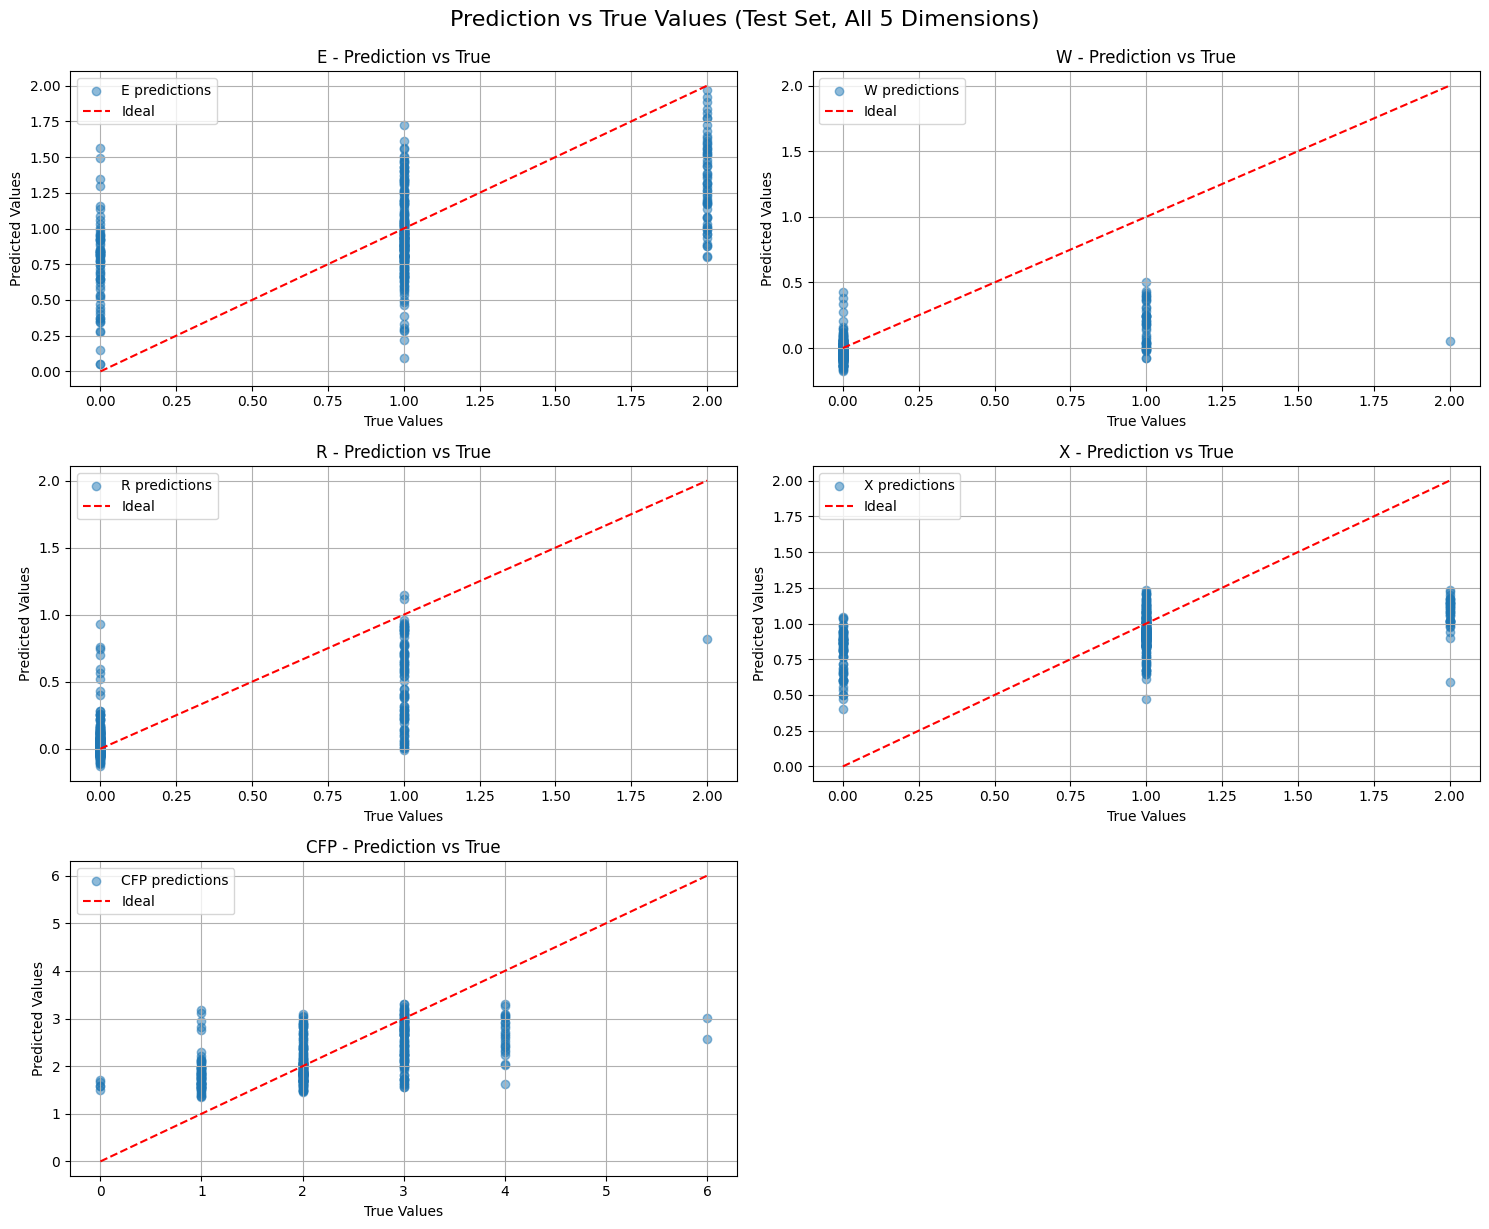

In [31]:
# Labels for each dimension including CFP
dimensions = ['E', 'W', 'R', 'X', 'CFP']

# Plot predictions vs actuals
plt.figure(figsize=(15, 12))

for i, dim in enumerate(dimensions):
    plt.subplot(3, 2, i + 1)
    plt.scatter(true[:, i], pred[:, i], alpha=0.5, label=f'{dim} predictions')
    plt.plot([true[:, i].min(), true[:, i].max()], [true[:, i].min(), true[:, i].max()], 'r--', label='Ideal')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{dim} - Prediction vs True')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Prediction vs True Values (Test Set, All 5 Dimensions)', fontsize=16, y=1.02)
plt.show()

In [32]:
print("\n==== Code Length and Docstring Length ====")

# Token length (Code)
code_lengths = df['Code'].apply(lambda x: len(tokenizer.tokenize(x)))
# Docstring word count
def get_docstring_length(docstring):
    if isinstance(docstring, str):
        return len(docstring.split())
    return 0
docstring_lengths = df['Docstring'].apply(get_docstring_length)

def print_stats(name, values):
    print(f"\n{name}")
    print(f"Min:     {np.min(values)}")
    print(f"Max:     {np.max(values)}")
    print(f"Mean:    {np.mean(values):.2f}")
    print(f"Median:  {np.median(values)}")
    print(f"Variance:{np.var(values):.2f}")
    print(f"StDev:   {np.std(values):.2f}")
    print(f"Total:   {np.sum(values)}")

print_stats("Code Length (# tokens)", code_lengths)
print_stats("Docstring Length (# words)", docstring_lengths)



==== Code Length and Docstring Length ====

Code Length (# tokens)
Min:     92
Max:     506
Mean:    252.23
Median:  231.0
Variance:10048.97
StDev:   100.24
Total:   450740

Docstring Length (# words)
Min:     0
Max:     2059
Mean:    81.66
Median:  57.0
Variance:11283.15
StDev:   106.22
Total:   145933
